In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plorts
from common import *
import matplotlib
plt.style.use(['plorts', 'plorts-print', './buffer-workshop.mplstyle'])
width = 7.141/3
matplotlib.rcParams['figure.figsize'] = (width, width*1/3)

In [2]:
prr = pd.read_sql("""
select * from experiments
where note in ('postcard', 'postcard-ecn')
  and algorithm = 'reno'
  and action = 'drop'
  and num_flows = 2
  and max_queue_depth_cells = 15000
""", con=con)
prr.head()

,index,action,algorithm,filename,id,max_queue_depth_bytes,max_queue_depth_cells,max_queue_depth_packets,mtu_bytes,num_flows,receiver_delay,note,run_at,pacing,pacing_factor,experimenter
0,None,drop,reno,results/86652240-8f13-11ea-8dea-0cc47aaaaa10/t...,86652240-8f13-11ea-8dea-0cc47aaaaa10,1200000,15000,133.333333,9000,2,1ms,postcard-ecn,2020-05-05 14:01:05.199801,False,1.0,bspang


In [3]:
trace = pd.read_sql("""
select * from traces
inner join experiments on experiments.id = experiment_id
where note in ('postcard-2sec')
  and algorithm = 'reno'
  and action = 'drop'
  and num_flows = 2
  and max_queue_depth_cells = 20000
  and sport != 22
  and dport != 22
""", con=con)
trace.head()

,index,data_len,dest,dport,mark,rcv_wnd,snd_cwnd,snd_nxt,snd_una,snd_wnd,...,max_queue_depth_cells,max_queue_depth_packets,mtu_bytes,num_flows,receiver_delay,note,run_at,pacing,pacing_factor,experimenter
0,None,0,10.0.0.1:5201,5201,0,65536,10,759634701,759634664,65535,...,20000,177.777778,9000,2,1ms,postcard-2sec,2020-05-12 12:44:33.280453,False,1.0,sarslan
1,None,1,10.0.0.1:5201,5201,0,65536,10,759634701,759634701,65536,...,20000,177.777778,9000,2,1ms,postcard-2sec,2020-05-12 12:44:33.280453,False,1.0,sarslan
2,None,0,10.0.0.1:5201,5201,0,65536,10,759634705,759634701,65536,...,20000,177.777778,9000,2,1ms,postcard-2sec,2020-05-12 12:44:33.280453,False,1.0,sarslan
3,None,0,10.0.0.1:5201,5201,0,65536,10,759634805,759634705,65536,...,20000,177.777778,9000,2,1ms,postcard-2sec,2020-05-12 12:44:33.280453,False,1.0,sarslan
4,None,1,10.0.0.1:5201,5201,0,65536,10,759634805,759634805,65536,...,20000,177.777778,9000,2,1ms,postcard-2sec,2020-05-12 12:44:33.280453,False,1.0,sarslan


In [4]:
postcards = pd.read_sql("""
select * from postcard_traces
inner join experiments on experiments.id = experiment_id
where note in ('postcard-2sec')
  and algorithm = 'reno'
  and action = 'drop'
  and num_flows = 2
  and max_queue_depth_cells = 20000
  and src_port != 22
  and dst_port != 22
  """, con=con)

In [5]:
trace['time_ms'] = trace['timestamp_sec']*1000
postcards['time_ms'] = postcards['timestamp_sec']*1000

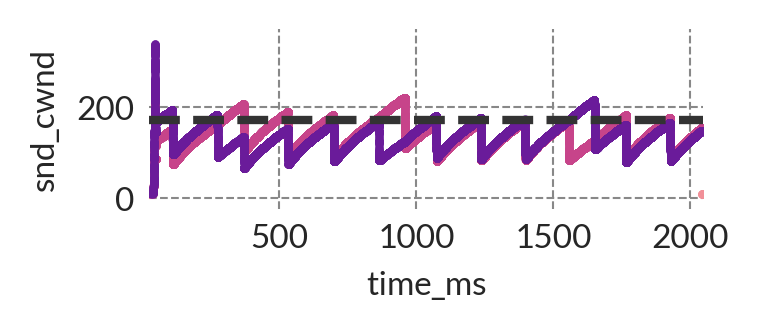

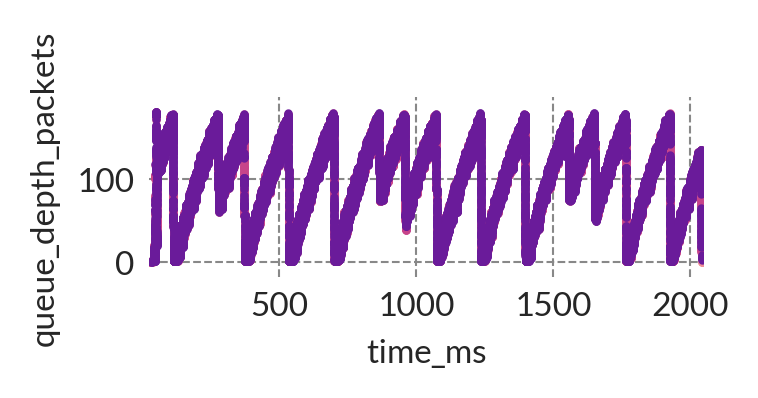

In [6]:
plorts.scatter(trace, x="time_ms", y="snd_cwnd", hue=["sport", "dport"], markersize=1)
plt.axhline(y=(166 + trace.iloc[0].max_queue_depth_packets)/2, color='#333333', linestyle="--", label="(BDP+B)/2")
plt.figure()
plorts.scatter(postcards, x="time_ms", y="queue_depth_packets", hue=["src_port", "dst_port"], markersize=1)

In [7]:
166 + postcards.iloc[0].max_queue_depth_packets

343.777777777778

/usr/local/lib/python3.9/site-packages/plorts/style.py:68: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


<Figure size 714.1x238.033 with 0 Axes>

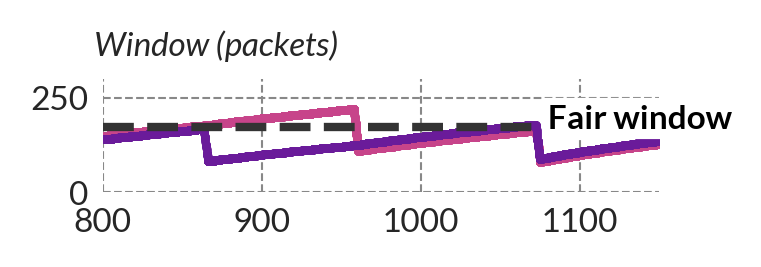

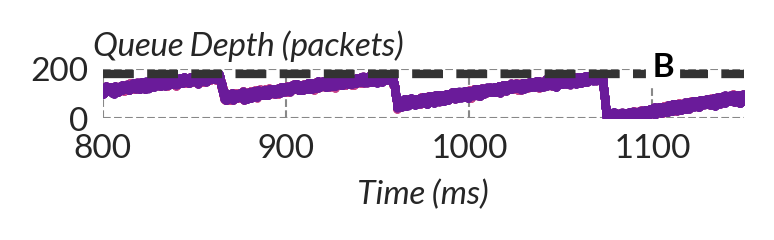

<Figure size 714.1x238.033 with 0 Axes>

In [8]:
xmin = 800
xmax= 1150

plt.figure(figsize=(width, 1/4*width))
plorts.scatter(trace, x="time_ms", y="snd_cwnd", hue=["sport", "dport"], markersize=1)
plt.axis(xmin=xmin, xmax=xmax, ymin=0, ymax=300)
plt.xlabel("")
#plt.xticks([200,250,300,350,400,450],[])
plt.ylabel("Window (packets)")
plt.axhline(y=(166 + trace.iloc[0].max_queue_depth_packets)/2, color='#333333', linestyle="--")
plt.text(1080, 170, "Fair window", fontweight='bold',bbox=dict(facecolor='white', edgecolor='white', pad=1))
plorts.style_axis(show_xaxis=True)
plorts.savefig("../figures/traces/unfairness-window.png")

plt.figure(figsize=(width, 1/4*width))

plorts.scatter(postcards, x="time_ms", y="queue_depth_packets", hue=["src_port", "dst_port"], markersize=1)
plt.axis(xmin=xmin, xmax=xmax, ymin=0, ymax=200)
plt.xlabel("Time (ms)")
plt.ylabel("Queue Depth (packets)")
plt.axhline(y=postcards.iloc[0].max_queue_depth_packets, color='#333333', linestyle="--")
plt.text(1100, 170, "B", fontweight='bold',bbox=dict(facecolor='white', edgecolor='white', pad=1))

plorts.style_axis(show_xaxis=True)
plorts.savefig("../figures/traces/unfairness-queues.png")

plt.figure()

In [9]:
trace = pd.read_sql("""
select * from traces
inner join experiments on experiments.id = experiment_id
where note in ('postcard-2sec')
  and algorithm = 'reno'
  and action = 'drop'
  and num_flows = 4
  and max_queue_depth_cells = 20000
  and sport != 22
  and dport != 22
""", con=con)
trace.head()

,index,data_len,dest,dport,mark,rcv_wnd,snd_cwnd,snd_nxt,snd_una,snd_wnd,...,max_queue_depth_cells,max_queue_depth_packets,mtu_bytes,num_flows,receiver_delay,note,run_at,pacing,pacing_factor,experimenter
0,None,0,10.0.0.1:5201,5201,0,65536,10,3773103458,3773103421,65535,...,20000,177.777778,9000,4,1ms,postcard-2sec,2020-05-12 12:44:46.359836,False,1.0,sarslan
1,None,1,10.0.0.1:5201,5201,0,65536,10,3773103458,3773103458,65536,...,20000,177.777778,9000,4,1ms,postcard-2sec,2020-05-12 12:44:46.359836,False,1.0,sarslan
2,None,0,10.0.0.1:5201,5201,0,65536,10,3773103462,3773103458,65536,...,20000,177.777778,9000,4,1ms,postcard-2sec,2020-05-12 12:44:46.359836,False,1.0,sarslan
3,None,0,10.0.0.1:5201,5201,0,65536,10,3773103562,3773103462,65536,...,20000,177.777778,9000,4,1ms,postcard-2sec,2020-05-12 12:44:46.359836,False,1.0,sarslan
4,None,1,10.0.0.1:5201,5201,0,65536,10,3773103562,3773103562,65536,...,20000,177.777778,9000,4,1ms,postcard-2sec,2020-05-12 12:44:46.359836,False,1.0,sarslan


In [10]:
postcards = pd.read_sql("""
select * from postcard_traces
inner join experiments on experiments.id = experiment_id
where note in ('postcard-2sec')
  and algorithm = 'reno'
  and action = 'drop'
  and num_flows = 4
  and max_queue_depth_cells = 20000
  and src_port != 22
  and dst_port != 22
  """, con=con)

In [11]:
trace['time_ms'] = trace['timestamp_sec']*1000
postcards['time_ms'] = postcards['timestamp_sec']*1000

<Figure size 714.1x238.033 with 0 Axes>

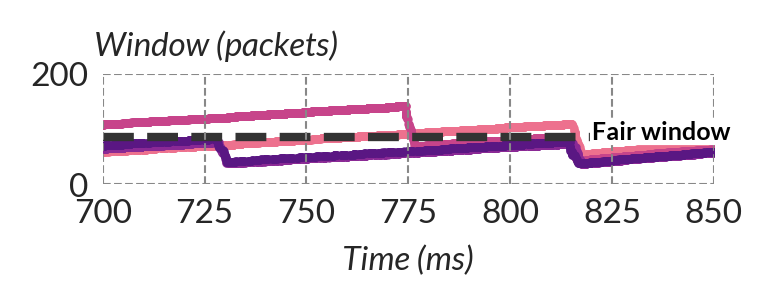

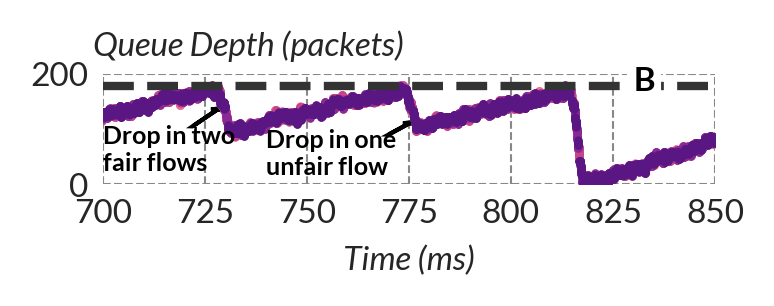

<Figure size 714.1x238.033 with 0 Axes>

In [12]:
xmin = 700
xmax= 850

plt.figure(figsize=(width, 1/3*width))
plorts.scatter(trace, x="time_ms", y="snd_cwnd", hue=["sport", "dport"], markersize=1, zorder=-1)
plt.axis(xmin=xmin, xmax=xmax, ymin=0, ymax=200)
plt.xlabel("Time (ms)")
#plt.xticks([200,250,300,350,400,450],[])
plt.ylabel("Window (packets)")
plt.text(820, 82, "Fair window", fontweight='bold',bbox=dict(facecolor='white', edgecolor='white', pad=0),zorder=1,
         fontsize=6)
plt.axhline(y=(166 + trace.iloc[0].max_queue_depth_packets)/4, color='#333333', linestyle="--", zorder=0)
plorts.style_axis(show_xaxis=True)
plorts.savefig("../figures/traces/unfairness-window-4.png")

plt.figure(figsize=(width, 1/3*width))

plorts.scatter(postcards, x="time_ms", y="queue_depth_packets", hue=["src_port", "dst_port"], markersize=1)
plt.axis(xmin=xmin, xmax=xmax, ymin=0, ymax=200)
plt.xlabel("Time (ms)")
plt.ylabel("Queue Depth (packets)")
plt.axhline(y=postcards.iloc[0].max_queue_depth_packets, color='#333333', linestyle="--")
plt.text(830, 170, "B", fontweight='bold',bbox=dict(facecolor='white', edgecolor='white', pad=1))

plt.text(700, 25, "Drop in two\nfair flows", fontweight='bold', fontsize=6)
plt.arrow(722,105,6,30,shape='full',head_width=3, head_length=3)

plt.text(740, 18, "Drop in one\nunfair flow", fontweight='bold', fontsize=6)
plt.arrow(770,90,5,20,shape='full',head_width=3, head_length=3)

plorts.style_axis(show_xaxis=True)
plorts.savefig("../figures/traces/unfairness-queues-4.png")

plt.figure()